In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
#a handful of sites
#sites = ['30000214','30013206','30030524','30033181','30033350','30033458','30033086','30022796','30031162','30025126','30031901','30029639','30025720','30019783','30030663','30008705','30031098','30032767']
sites = ['Customer1','Customer2','Customer3','Customer4','Customer5','Customer6','Customer7','Customer8','Customer9','Customer10','Customer11','Customer12','Customer13','Customer14','Customer15','Customer16','Customer17','Customer18']





latlng = ['latitude', 'longitude']
#position = pd.read_csv('./data/position.csv', index_col="City")
position=pd.read_excel(r'C:\Users\bazrekar\pythonclass\Position.xlsx', index_col="City")
#distance = pd.read_csv('./data/distance.csv', index_col="City")
distance=pd.read_excel(r'C:\Users\bazrekar\pythonclass\dis.xlsx', index_col="City")
position.head(5)
# print(len(sites))


,Latitude,Longitude
City,,
Customer1,38.066119,46.298708
Customer2,38.070592,46.339829
Customer3,38.079814,46.289940
Customer4,38.066412,46.365059
Customer5,38.072917,46.300338


In [4]:
#make some positions (so we can plot this)
positions = dict( ( City, (position.loc[City,'Longitude'], position.loc[City,'Latitude']) ) for City in sites)

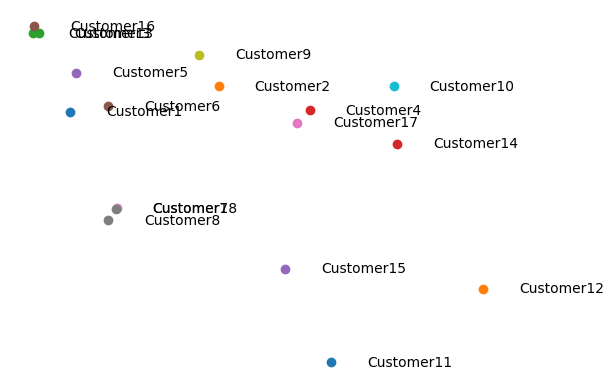

In [5]:
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
plt.gca().axis('off');

In [6]:
# get distanc between cities
distances = dict( ((s1,s2), distance.loc[s1, s2] ) for s1 in positions for s2 in positions if s1!=s2)

In [7]:
K = 4 #the number of car 

In [1]:
pip install pulp 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pulp (from versions: none)
ERROR: No matching distribution found for pulp


In [9]:
from PuLP import *
#create the problme
prob=LpProblem("vehicle", LpMinimize)

In [3]:
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

In [ ]:
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

In [ ]:
#constraints
for k in sites:
    cap = 1 if k != 'Customer1' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'Customer1' and j!= 'Customer1') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

In [ ]:
%time prob.solve()
#prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])

In [ ]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

In [ ]:
tours = get_next_site('Customer1')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='Customer1':
        t.append(get_next_site(t[-1][1])[-1])

In [ ]:
for t in tours:
    print(' -> '.join([ a for a,b in t]+['Customer1']))

In [ ]:
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.title('%d '%K + 'people' if K > 1 else 'person')
plt.xlabel('latitude')
plt.ylabel('longitude')
# plt.gca().axis('off')
plt.show()

In [ ]:
print('Total distance:', value(prob.objective), '(km)')